<a href="https://colab.research.google.com/github/Nishan-Charlie/MedNET_FYP/blob/main/MedNET_TransferLearning_HER2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import warnings
import sys
from keras import backend as K
from keras.applications import VGG16
from keras.preprocessing import image

warnings.simplefilter(action='ignore', category = FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Load the model from the .h5 file
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/FYP/MedNET_FeatureExtractor_Vgg16.h5')

In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
layers = loaded_model.layers
filters, biases = loaded_model.layers[1].get_weights()
print(layers[16].name, filters.shape)

block5_conv3 (3, 3, 64, 64)


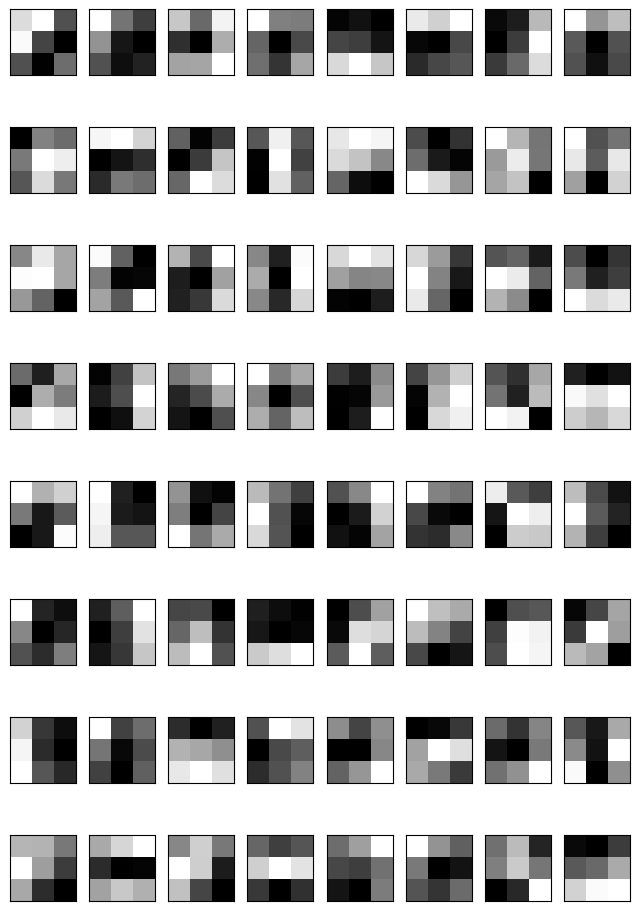

In [ ]:
fig1 = plt.figure(figsize=(8,12))
columns = 8
rows = 8
n_filters = columns * rows

for i in range(1, n_filters+1):
  f = filters[:,:,:,i-1]
  fig1 = plt.subplot(rows,columns,i)
  fig1.set_xticks([])
  fig1.set_yticks([])
  plt.imshow(f[:,:,0], cmap ='gray')

plt.show()

In [ ]:
model = Sequential()

model = Sequential()
for layer in loaded_model.layers[:-1]:
  model.add(layer)

#HER2 Samples

In [ ]:
base  = "/content/drive/MyDrive/Colab Notebooks/FYP/Her2 - 2classesv02"

In [ ]:
train_path = os.path.join(base, 'Train')
# valid_path = os.path.join(base, 'valid')
test_path =  os.path.join(base, 'Test')
print(len(os.listdir(train_path)))

2


In [ ]:
classes = os.listdir(train_path)
dataGenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,validation_split=0.1)

In [ ]:
train_batches = dataGenerator.flow_from_directory(directory=train_path, target_size=(224, 224), classes=classes, batch_size=32,class_mode='categorical',subset='training')
valid_batches = dataGenerator.flow_from_directory(directory= train_path, target_size = (224,224),classes = classes, batch_size = 16,class_mode='categorical',subset='validation')
test_batches =  ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = test_path, target_size=(224,224),classes =classes, batch_size = 16, shuffle = False,class_mode='categorical',subset='training')

Found 1446 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


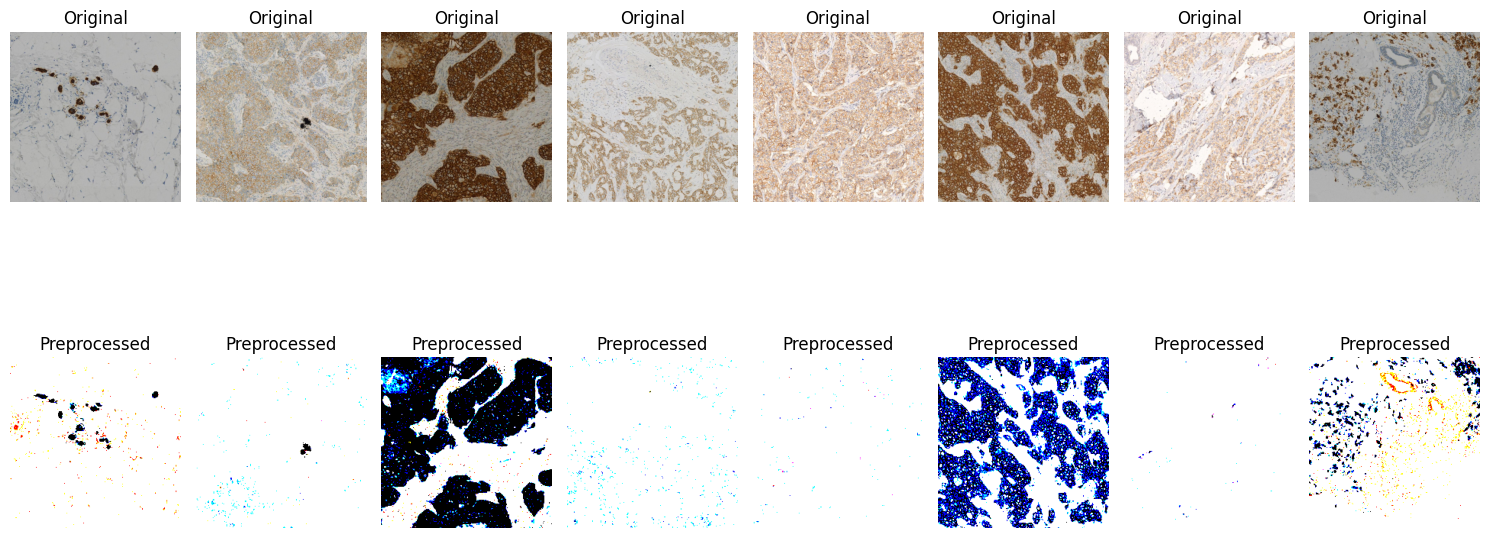

In [ ]:
image_path = base+'/Train/Pos'
image_files = os.listdir(image_path)
fig, axes = plt.subplots(2, 8, figsize=(15, 8))

for i in range(8):
    # Select a random image file
    random_image_file = random.choice(image_files)

    # Open and display the original image using Pillow
    image = os.path.join(image_path, random_image_file)
    img = PIL.Image.open(image)

    # Preprocess the image for VGG16
    img_preprocessed = img.resize((224, 224))  # Resize to 224x224 pixels
    img_preprocessed = tf.keras.applications.vgg16.preprocess_input(np.array(img_preprocessed))  # Preprocess pixel values

    # Display the original image
    axes[0, i].imshow(img)
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')  # Turn off axis labels

    # Display the preprocessed image
    axes[1, i].imshow(img_preprocessed)
    axes[1, i].set_title("Preprocessed")
    axes[1, i].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

In [ ]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1,10, figsize = (20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
imgs, labels = next(train_batches)

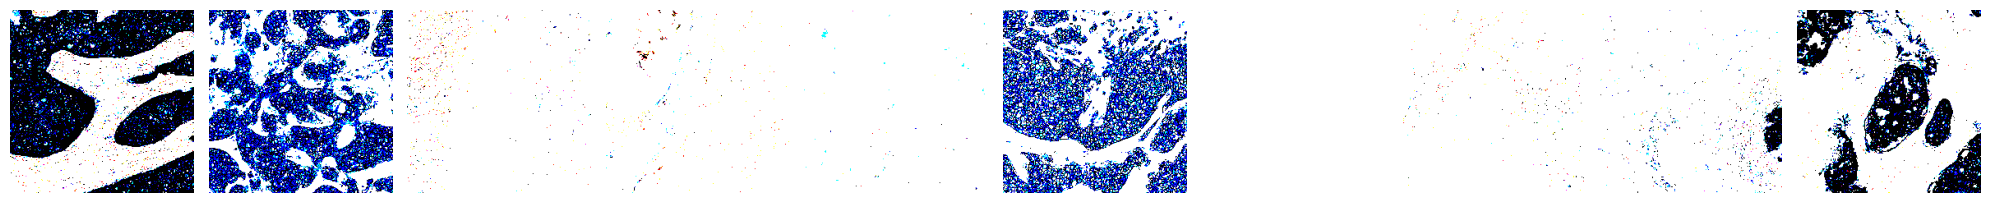

In [ ]:
plotImages(imgs)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title='Confusin Matrix', cmap = plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm = cm.astype('flot')/ cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  print(cm)
  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i,cm[i,j],
             horizontalalignment = "center",
             color="white" if cm[i,j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
for layer in model.layers:
  layer.trainable = False

In [ ]:
model.add(Dense(units=2, activation = 'softmax'))


NameError: ignored

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_data = train_batches[0][0]  # Access the first batch of data
batch_shape = batch_data.shape
print("Batch data shape:", batch_shape)

Batch data shape: (32, 224, 224, 3)


In [ ]:
train_batches.class_indices

{'Neg': 0, 'Pos': 1}

In [ ]:
history = model.fit(x= train_batches, validation_data = valid_batches, epochs = 50, verbose= 2)

Epoch 1/50
46/46 - 266s - loss: 0.8398 - accuracy: 0.4952 - val_loss: 0.5671 - val_accuracy: 0.7000 - 266s/epoch - 6s/step
Epoch 2/50
46/46 - 16s - loss: 0.5110 - accuracy: 0.7863 - val_loss: 0.4870 - val_accuracy: 0.8062 - 16s/epoch - 358ms/step
Epoch 3/50
46/46 - 16s - loss: 0.4781 - accuracy: 0.7981 - val_loss: 0.4728 - val_accuracy: 0.7875 - 16s/epoch - 348ms/step
Epoch 4/50
46/46 - 17s - loss: 0.4682 - accuracy: 0.7994 - val_loss: 0.4691 - val_accuracy: 0.7937 - 17s/epoch - 366ms/step
Epoch 5/50
46/46 - 18s - loss: 0.4638 - accuracy: 0.8015 - val_loss: 0.4641 - val_accuracy: 0.7625 - 18s/epoch - 386ms/step
Epoch 6/50
46/46 - 16s - loss: 0.4590 - accuracy: 0.8015 - val_loss: 0.4634 - val_accuracy: 0.8000 - 16s/epoch - 358ms/step
Epoch 7/50
46/46 - 16s - loss: 0.4538 - accuracy: 0.8008 - val_loss: 0.4597 - val_accuracy: 0.7812 - 16s/epoch - 354ms/step
Epoch 8/50
46/46 - 16s - loss: 0.4508 - accuracy: 0.8015 - val_loss: 0.4582 - val_accuracy: 0.7812 - 16s/epoch - 357ms/step
Epoch 9/5

In [ ]:
# Save training history to a log file
with open(base+'training_log_Vgg16_from_MEDNET.txt', 'w') as log_file:
    log_file.write("Training Loss:\n")
    log_file.write(str(history.history['loss']) + '\n')
    log_file.write("Validation Loss:\n")
    log_file.write(str(history.history['val_loss']) + '\n')
    log_file.write("Training Accuracy:\n")
    log_file.write(str(history.history['accuracy']) + '\n')
    log_file.write("Validation Accuracy:\n")
    log_file.write(str(history.history['val_accuracy']) + '\n')

In [ ]:
model.save(base+"HER2Sample_VGG16_Trasfered_From_MedNET.h5")

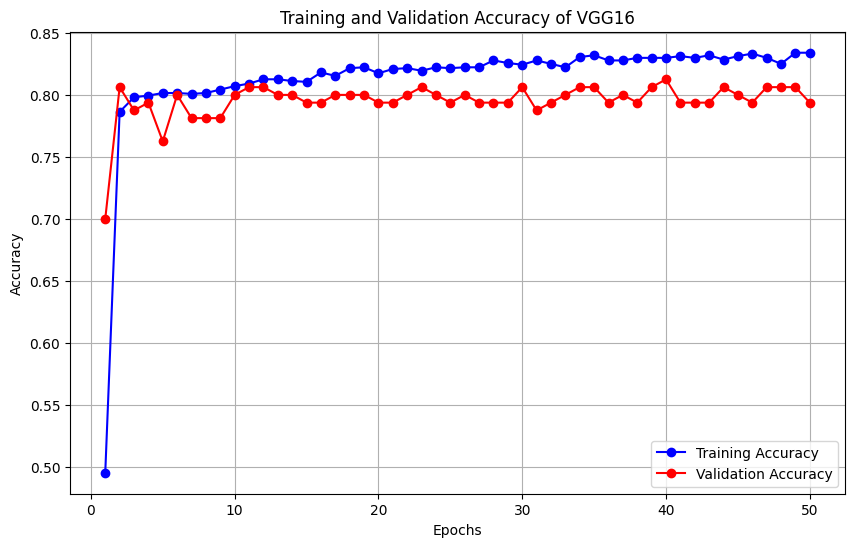

In [ ]:
# Extract training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, 51)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_batches)

print("Testing Accuracy:", test_accuracy)

15/15 [==============================] - 3s 197ms/step - loss: 0.4268 - accuracy: 0.8167
Testing Accuracy: 0.8166666626930237


In [ ]:
predictions =model.predict(x= test_batches, verbose=2)
cm = confusion_matrix(y_true= test_batches.classes, y_pred = np.argmax(predictions, axis=-1))

15/15 - 61s - 61s/epoch - 4s/step


Confusion matrix, without normalization
[[128  17]
 [ 27  68]]


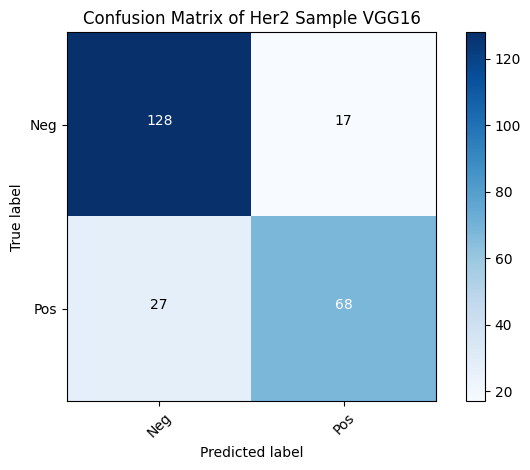

In [ ]:
plot_confusion_matrix(cm=cm, classes=classes, title = 'Confusion Matrix of Her2 Sample VGG16')

#BreaKHis 400X


In [ ]:
base = "/content/drive/MyDrive/Colab Notebooks/FYP/BreaKHis 400X"

In [ ]:
train_path = os.path.join(base, 'train')
test_path =  os.path.join(base, 'test')
print(len(os.listdir(train_path)))

2


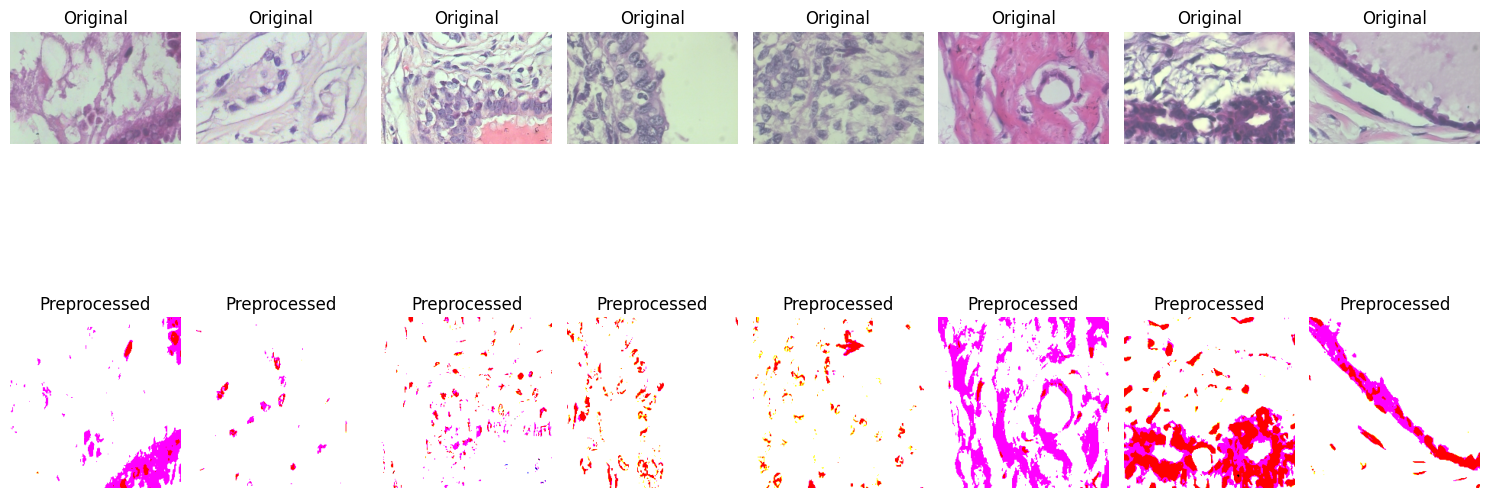

In [ ]:
image_path = base+'/train/benign'
image_files = os.listdir(image_path)
fig, axes = plt.subplots(2, 8, figsize=(15, 8))

for i in range(8):
    # Select a random image file
    random_image_file = random.choice(image_files)

    # Open and display the original image using Pillow
    image = os.path.join(image_path, random_image_file)
    img = PIL.Image.open(image)

    # Preprocess the image for VGG16
    img_preprocessed = img.resize((224, 224))  # Resize to 224x224 pixels
    img_preprocessed = tf.keras.applications.vgg16.preprocess_input(np.array(img_preprocessed))  # Preprocess pixel values

    # Display the original image
    axes[0, i].imshow(img)
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')  # Turn off axis labels

    # Display the preprocessed image
    axes[1, i].imshow(img_preprocessed)
    axes[1, i].set_title("Preprocessed")
    axes[1, i].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

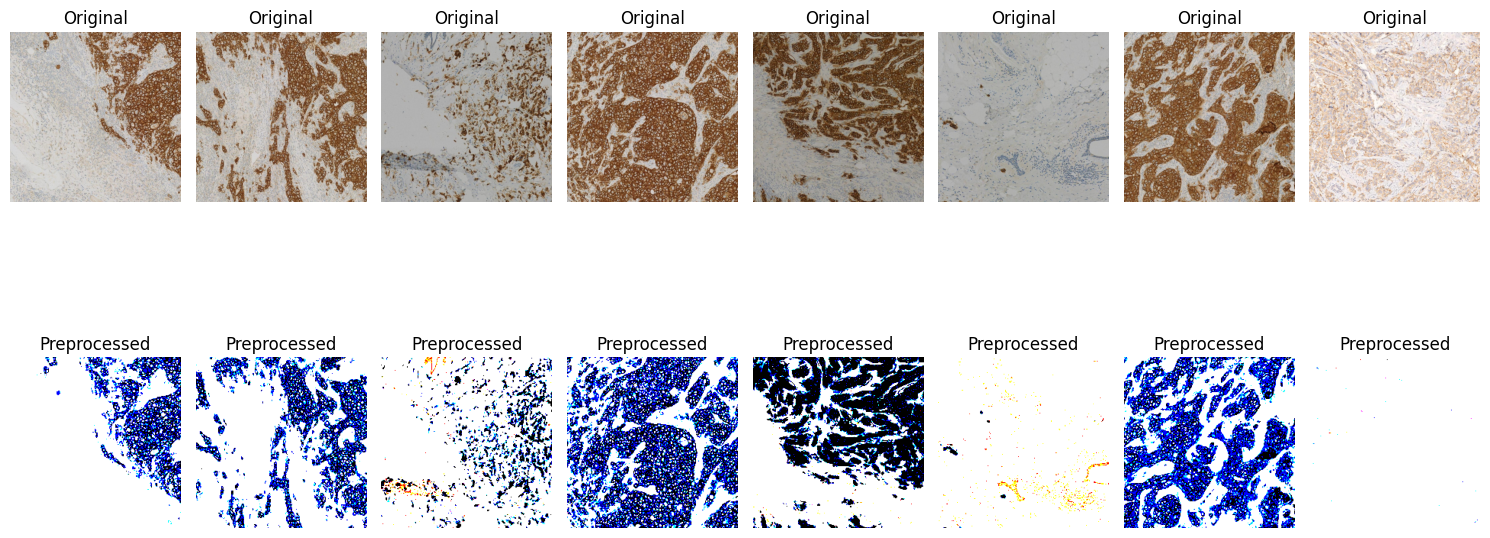

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import PIL.Image
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input

# Set a random seed for reproducibility
random.seed(42)

image_path = '/content/drive/MyDrive/Colab Notebooks/FYP/Her2 - 2classesv02/Train/Pos'
image_files = os.listdir(image_path)
fig, axes = plt.subplots(2, 8, figsize=(15, 8))

for i in range(8):
    # Select a random image file
    random_image_file = random.choice(image_files)

    # Open and display the original image using Pillow
    image = os.path.join(image_path, random_image_file)
    img = PIL.Image.open(image)

    # Preprocess the image for VGG16
    img_preprocessed = img.resize((224, 224))  # Resize to 224x224 pixels
    img_preprocessed = preprocess_input(np.array(img_preprocessed))  # Preprocess pixel values

    # Display the original image (normalized to [0, 1])
    axes[0, i].imshow(np.array(img) / 255.0)  # Normalize pixel values
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')  # Turn off axis labels

    # Display the preprocessed image (normalized to [0, 1])
    axes[1, i].imshow(img_preprocessed)
    axes[1, i].set_title("Preprocessed")
    axes[1, i].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()


In [ ]:
classes = os.listdir(train_path)
dataGenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,validation_split=0.1)

In [ ]:
train_batches = dataGenerator.flow_from_directory(directory=train_path, target_size=(224, 224), classes=classes, batch_size=32,class_mode='categorical',subset='training')
valid_batches = dataGenerator.flow_from_directory(directory= train_path, target_size = (224,224),classes = classes, batch_size = 16,class_mode='categorical',subset='validation')
test_batches =  ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = test_path, target_size=(224,224),classes =classes, batch_size = 16, shuffle = False,class_mode='categorical',subset='training')

Found 727 images belonging to 2 classes.
Found 79 images belonging to 2 classes.
Found 545 images belonging to 2 classes.


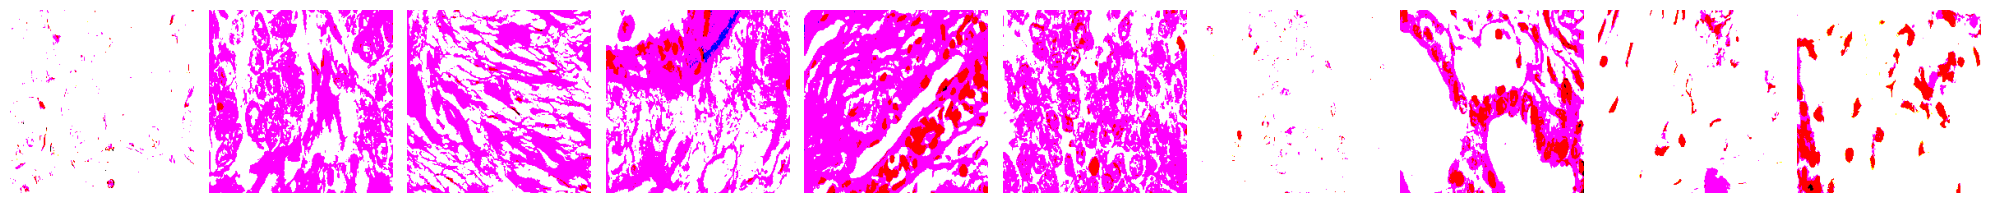

In [ ]:
imgs, labels = next(train_batches)
plotImages(imgs)

In [ ]:
batch_data = train_batches[0][0]  # Access the first batch of data
batch_shape = batch_data.shape
print("Batch data shape:", batch_shape)

Batch data shape: (32, 224, 224, 3)


In [ ]:
model = Sequential()

model = Sequential()
for layer in loaded_model.layers[:-1]:
  model.add(layer)

In [ ]:
for layer in model.layers:
  layer.trainable = False

In [ ]:
model.add(Dense(units=2, activation = 'softmax'))


In [ ]:
train_batches.class_indices

{'malignant': 0, 'benign': 1}

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x= train_batches, validation_data = valid_batches, epochs = 50, verbose= 2)

Epoch 1/50
23/23 - 93s - loss: 0.7106 - accuracy: 0.5062 - val_loss: 0.6942 - val_accuracy: 0.5949 - 93s/epoch - 4s/step
Epoch 2/50
23/23 - 13s - loss: 0.7022 - accuracy: 0.5076 - val_loss: 0.6976 - val_accuracy: 0.5823 - 13s/epoch - 555ms/step
Epoch 3/50
23/23 - 13s - loss: 0.6896 - accuracy: 0.5777 - val_loss: 0.6995 - val_accuracy: 0.5696 - 13s/epoch - 551ms/step
Epoch 4/50
23/23 - 13s - loss: 0.6826 - accuracy: 0.5626 - val_loss: 0.6925 - val_accuracy: 0.5949 - 13s/epoch - 566ms/step
Epoch 5/50
23/23 - 13s - loss: 0.6744 - accuracy: 0.5763 - val_loss: 0.6979 - val_accuracy: 0.5949 - 13s/epoch - 558ms/step
Epoch 6/50
23/23 - 13s - loss: 0.6702 - accuracy: 0.5901 - val_loss: 0.7052 - val_accuracy: 0.4937 - 13s/epoch - 550ms/step
Epoch 7/50
23/23 - 13s - loss: 0.6775 - accuracy: 0.5763 - val_loss: 0.7022 - val_accuracy: 0.5949 - 13s/epoch - 551ms/step
Epoch 8/50
23/23 - 13s - loss: 0.6720 - accuracy: 0.5585 - val_loss: 0.7052 - val_accuracy: 0.5949 - 13s/epoch - 553ms/step
Epoch 9/50


In [ ]:
model.save(base+"BreakHis400X_VGG16_Trasfered_From_MedNET.h5")

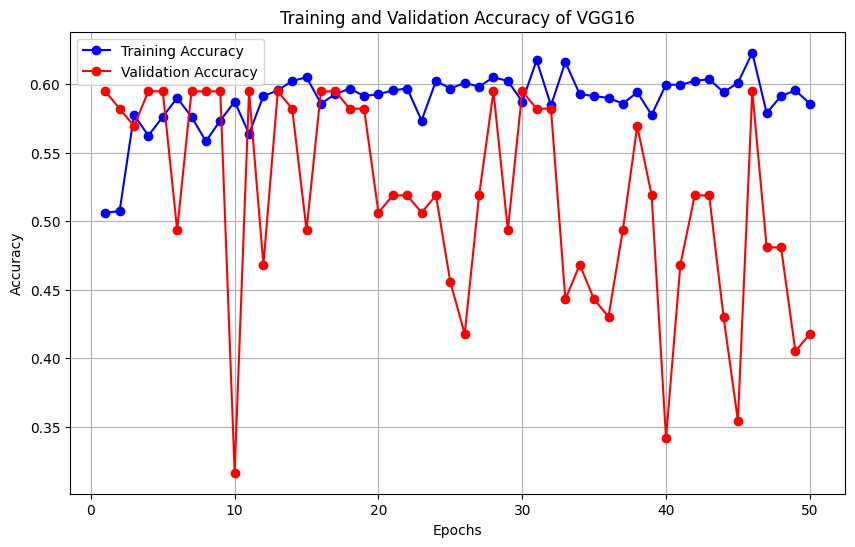

In [ ]:
# Extract training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, 51)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_batches)

print("Testing Accuracy:", test_accuracy)

35/35 [==============================] - 146s 4s/step - loss: 0.6484 - accuracy: 0.6183
Testing Accuracy: 0.6183485984802246


35/35 - 9s - 9s/epoch - 263ms/step
Confusion matrix, without normalization
[[281  88]
 [120  56]]


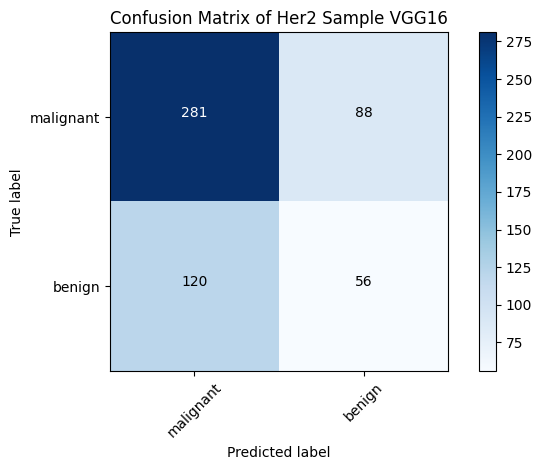

In [ ]:
predictions =model.predict(x= test_batches, verbose=2)
cm = confusion_matrix(y_true= test_batches.classes, y_pred = np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=classes, title = 'Confusion Matrix of Her2 Sample VGG16')

#Transfer Learning only For BreakHis 400X

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 5s 0us/step


In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

In [ ]:
for layer in model.layers:
  layer.trainable = False

In [ ]:
model.add(Dense(units=2, activation = 'softmax'))

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x= train_batches, validation_data = valid_batches, epochs = 50, verbose= 2)

Epoch 1/50
23/23 - 16s - loss: 0.9995 - accuracy: 0.4897 - val_loss: 0.6435 - val_accuracy: 0.5696 - 16s/epoch - 708ms/step
Epoch 2/50
23/23 - 14s - loss: 0.7257 - accuracy: 0.6204 - val_loss: 0.5456 - val_accuracy: 0.6709 - 14s/epoch - 595ms/step
Epoch 3/50
23/23 - 13s - loss: 0.6057 - accuracy: 0.6836 - val_loss: 0.5071 - val_accuracy: 0.7215 - 13s/epoch - 551ms/step
Epoch 4/50
23/23 - 13s - loss: 0.5339 - accuracy: 0.7290 - val_loss: 0.4719 - val_accuracy: 0.7595 - 13s/epoch - 559ms/step
Epoch 5/50
23/23 - 14s - loss: 0.4895 - accuracy: 0.7785 - val_loss: 0.4510 - val_accuracy: 0.7848 - 14s/epoch - 593ms/step
Epoch 6/50
23/23 - 13s - loss: 0.4579 - accuracy: 0.7813 - val_loss: 0.4955 - val_accuracy: 0.7089 - 13s/epoch - 556ms/step
Epoch 7/50
23/23 - 13s - loss: 0.4279 - accuracy: 0.8047 - val_loss: 0.4495 - val_accuracy: 0.7722 - 13s/epoch - 552ms/step
Epoch 8/50
23/23 - 13s - loss: 0.4110 - accuracy: 0.8143 - val_loss: 0.4474 - val_accuracy: 0.7848 - 13s/epoch - 556ms/step
Epoch 9/

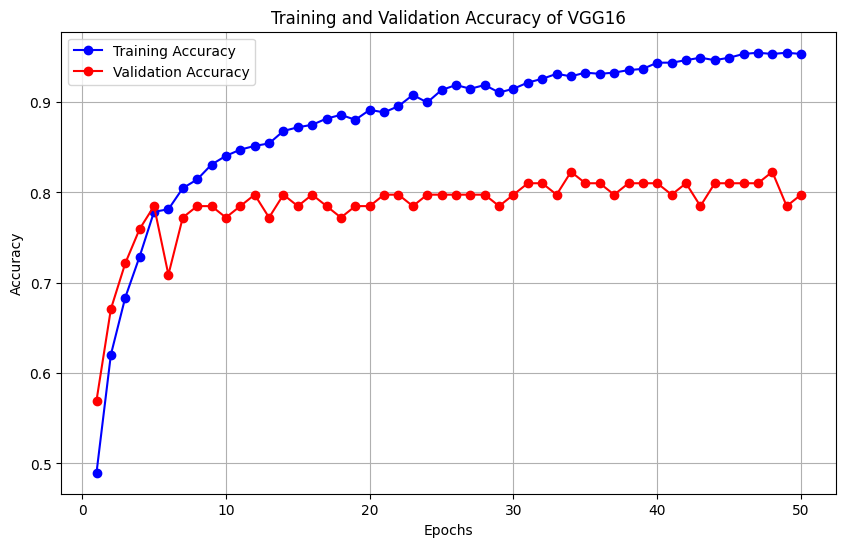

In [ ]:
# Extract training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, 51)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_batches)

print("Testing Accuracy:", test_accuracy)

35/35 [==============================] - 9s 240ms/step - loss: 0.3131 - accuracy: 0.8789
Testing Accuracy: 0.878899097442627


#ON Her2 Sample with different preprocessing